In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Mon Apr 14 13:08:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# 安装Kaggle库
!pip install -q kaggle

# 上传kaggle.json文件（点击左侧文件夹图标上传）
from google.colab import files
files.upload()  # 选择刚下载的kaggle.json

# 移动密钥到正确位置
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # 设置权限

Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets list

401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/datasets/list?group=public&sortby=hottest&size=all&filetype=all&license=all&viewed=unspecified&page=1


In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [8]:
!ls -lh /content/*.zip

-rw-r--r-- 1 root root 2.3G Sep 28  2019 /content/chest-xray-pneumonia.zip


In [9]:
#解压zip文件
!unzip -o /content/chest-xray-pneumonia.zip -d /content/data

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/dat

In [10]:
#检验解压结果
!ls /content/data/chest_xray
!ls /content/data/chest_xray/train

chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA


In [11]:
#检验样本数量
import os
print("训练集-肺炎:", len(os.listdir("/content/data/chest_xray/train/PNEUMONIA")))
print("训练集-正常:", len(os.listdir("/content/data/chest_xray/train/NORMAL")))

训练集-肺炎: 3875
训练集-正常: 1341


In [13]:
#数据预处理
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 设置训练集和验证集的生成器
train_datagen = ImageDataGenerator(
    rescale=1./255,         # 归一化像素值
    shear_range=0.2,        # 随机错切变换
    zoom_range=0.2,         # 随机缩放
    horizontal_flip=True,   # 随机水平翻转
    validation_split=0.2    # 划分20%数据作为验证集
)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    '/content/data/chest_xray/train',  # 修改为你的实际路径
    target_size=(150, 150),            # 统一图像尺寸
    batch_size=32,
    class_mode='binary',               # 二分类模式
    subset='training'                  # 指定训练集
)

# 验证集生成器
val_generator = train_datagen.flow_from_directory(
    '/content/data/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'                # 指定验证集
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [14]:
#构建模型 快速CNN模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # 二分类输出层
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # 自动计算每轮的步数
    epochs=10,                            # 训练轮次
    validation_data=val_generator,
    validation_steps=len(val_generator))

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 546ms/step - accuracy: 0.9417 - loss: 0.1462 - val_accuracy: 0.9195 - val_loss: 0.1847
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.9513 - loss: 0.1350 - val_accuracy: 0.9377 - val_loss: 0.1566
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 491ms/step - accuracy: 0.9519 - loss: 0.1245 - val_accuracy: 0.9338 - val_loss: 0.1601
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 497ms/step - accuracy: 0.9520 - loss: 0.1322 - val_accuracy: 0.9434 - val_loss: 0.1377
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 503ms/step - accuracy: 0.9492 - loss: 0.1168 - val_accuracy: 0.9386 - val_loss: 0.1363
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.9513 - loss: 0.1286 - val_accuracy: 0.9511 - val_loss: 0.1340
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 506ms/step - accuracy: 0.9523 - loss: 0.1236 - val_accuracy: 0.9348 - val_loss: 0.1649
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.9491 - loss: 0

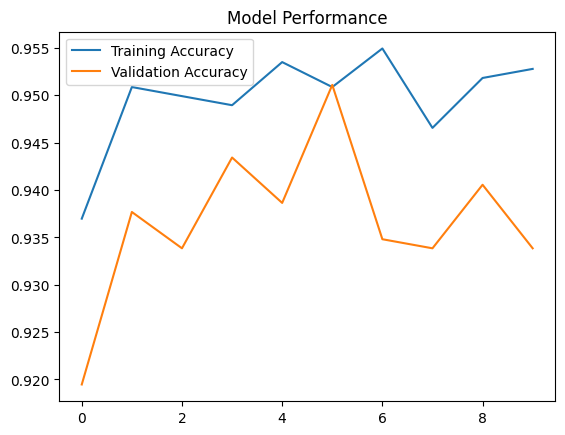

In [20]:
#评估模型
import matplotlib.pyplot as plt

# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

In [21]:
model.save('/content/pneumonia_model.h5')  # 保存模型
from google.colab import files
files.download('/content/pneumonia_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#模型评估与预测
test_datagen = ImageDataGenerator(rescale=1./255)  # 仅归一化

test_generator = test_datagen.flow_from_directory(
    '/content/data/chest_xray/test',  # 测试集路径
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # 测试集不需要打乱
)

# 评估模型
test_loss, test_acc = model.evaluate(test_generator)
print(f'测试集准确率: {test_acc:.2%}')

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.7165 - loss: 1.0756
测试集准确率: 84.78%


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step


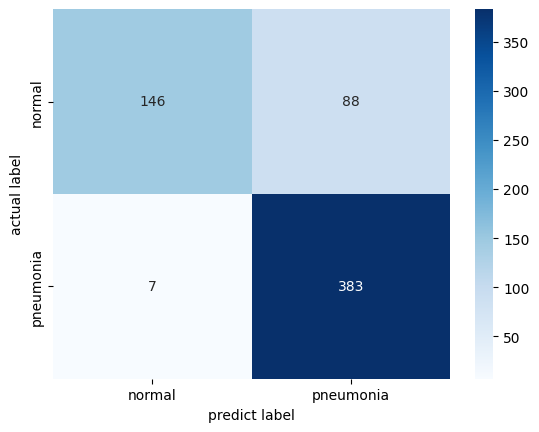

In [25]:
#可视化混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# 获取测试集真实标签和预测结果
test_generator.reset()  # 重置生成器
y_true = test_generator.classes
y_pred = model.predict(test_generator) > 0.5  # 二分类阈值=0.5

# 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'pneumonia'],
            yticklabels=['normal', 'pneumonia'])
plt.xlabel('predict label')
plt.ylabel('actual label')
plt.show()

In [26]:
#实际应用 单张x光片预测
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_pneumonia(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.  # 归一化
    pred = model.predict(x)
    return "pneumonia" if pred > 0.5 else "normal"

# 示例使用
print(predict_pneumonia("/content/data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
pneumonia
